# Object Detection Data Set (Pikachu)

There are no small data sets, like MNIST or Fashion-MNIST, in the object detection field. In order to quickly test models, we are going to assemble a small data set. First, we generate 1000 Pikachu images of different angles and sizes using an open source 3D Pikachu model. Then, we collect a series of background images and place a Pikachu image at a random position on each image.


## Download the Data Set

The Pikachu data set in RecordIO format can be downloaded directly from the Internet. The operation for downloading the data set is defined in the function `download_pikachu`.

In [1]:
%matplotlib inline
import sys
sys.path.insert(0, '..')
import d2l
import os
import torch
import torchvision.transforms as transforms
import json
import numpy as np
from PIL import Image

In [2]:
def download_pikachu(data_dir):
    root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
                'gluon/dataset/pikachu/')
    dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
               'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
               'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
    for k, v in dataset.items():
        d2l.download_url(root_url + k, data_dir)

d2l.download_and_preprocess_data()

## Convert Dataset to .PNG Images

The functions used for converting the RecordIO files to png images for using in a pytorch model are defined in the file `ssd_utils.py` present the the d2l folder of home directory.

## Read the Dataset

We created a class `PIKACHU` which loads the annotation file (json) which contains image names along with their bounding box annotations. Then we create a pytorch `DataLoader` using this class for iteratively extract the data by reading the image files and returning them in a random order while training. We don't need random order while testing.

In [3]:
# Create Dataloaders in Pytorch 
class PIKACHU(torch.utils.data.Dataset):
    def __init__(self, data_dir, set, transform=None, target_transform=None):
        
        self.image_size = (3, 256, 256)
        self.images_dir = os.path.join(data_dir, set, 'images')

        self.set = set
        self.transform = transforms.Compose([
            transforms.ToTensor()])
        self.target_transform = target_transform

        annotations_file = os.path.join(data_dir, set, 'annotations.json')
        with open(annotations_file) as file:
            self.annotations = json.load(file)

    def __getitem__(self, index):
        
        annotations_i = self.annotations['data_' + str(index+1)]
        
        image_path = os.path.join(self.images_dir, annotations_i['image'])
        img = np.array(Image.open(image_path).convert('RGB').resize((self.image_size[2], self.image_size[1]), Image.BILINEAR))
        # print(img.shape)
        loc = np.array(annotations_i['loc'])
        
        loc_chw = np.zeros((4,))
        loc_chw[0] = (loc[0] + loc[2])/2
        loc_chw[1] = (loc[1] + loc[3])/2
        loc_chw[2] = (loc[2] - loc[0])  #width
        loc_chw[3] = (loc[3] - loc[1])  # height
        

        label = 1 - annotations_i['class']
    
        if self.transform is not None:
            img = self.transform(img)       
        return (img, loc_chw, label)

    def __len__(self):
        return len(self.annotations)

In [4]:
data_dir = '../data/pikachu/'
train_dataset = PIKACHU(data_dir, 'train')
val_dataset = PIKACHU(data_dir, 'val')

Below, we read a mini-batch and print the shape of the image, groundtruth bounding-box and label. The shape of the image is the same as in the previous experiment (batch size, number of channels, height, width). The shape of the groundtruth bounding-box is (batch size, $m$, 4), where $m$ is equal to the maximum number of bounding boxes contained in a single image in the data set. The shape of the label is (batch size, $m$), where $m$ is equal to the maximum number of bounding boxes contained in a single image in the data set. Although computation for the mini-batch is very efficient, it requires each image to contain the same number of bounding boxes so that they can be placed in the same batch. Since each image may have a different number of bounding boxes, we can add illegal bounding boxes to images that have less than $m$ bounding boxes until each image contains $m$ bounding boxes. Thus, we can read a mini-batch of images each time. When the value of label for a particular bounding-box is -1, the bounding box is an illegal bounding box for filling purpose. The remaining four elements of the array represent the $x, y$ axis coordinates of the center of the bounding box and the $height$ and $width$ of the bounding box (the value range is between 0 and 1). The Pikachu data set here has only one bounding box per image, so $m=1$.

In [5]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=4)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size, shuffle=False,
                                         num_workers=4)
batch = next(iter(train_loader))

print(batch[0].shape, batch[1].shape, batch[2].shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 4]) torch.Size([32])


## Graphic Data

We have ten images with bounding boxes on them. We can see that the angle, size, and position of Pikachu are different in each image. Of course, this is a simple man-made data set. In actual practice, the data is usually much more complicated.

In [6]:
imgs = [train_dataset[i][0].permute(1,2,0) for i in range(10)]
labels = [d2l.center_2_hw(torch.Tensor(train_dataset[i][1]).unsqueeze(0)) for i in range(10)]

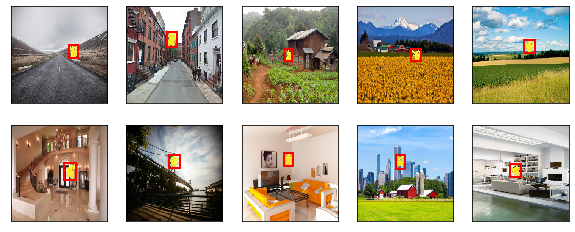

In [7]:
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, labels):
    d2l.show_bboxes(ax, [label.squeeze(0)*256], colors=['r'])

## Summary

* The Pikachu data set we synthesized can be used to test object detection models.
* The data reading for object detection is similar to that for image classification. However, after we introduce bounding boxes, the label shape and image augmentation (e.g., random cropping) are changed.


## Exercises

* Referring to the MXNet documentation, what are the parameters for the constructors of the `image.ImageDetIter` and `image.CreateDetAugmenter` classes? What is their significance?